In [1]:
import sys
import os

# Critical: Set env var FIRST
os.environ['CUDA_VISIBLE_DEVICES'] = ''

# Remove any existing torch.cuda
if 'torch' in sys.modules:
    sys.modules.pop('torch', None)
if 'torch.cuda' in sys.modules:
    sys.modules.pop('torch.cuda', None)

# Block CUDA submodule loading
original_import = __import__
def no_cuda_import(name, *args, **kwargs):
    if 'cuda' in str(name).lower():
        return None
    return original_import(name, *args, **kwargs)
__import__ = no_cuda_import

# Now safe to import torch
import torch


In [2]:
import matplotlib.pyplot as plt
import json
#from Gene_CA_Arc_priors import scheduler
from NCA import *
import utils
from IPython.display import Image, HTML, clear_output
import arc_agi_utils as aau
import random
import vft
from utils import make_path, create_empty_json


In [3]:
def safe_cuda(tensor):
    """Replace .cuda() calls - returns tensor on CPU"""
    return tensor

# Monkeypatch Tensor.cuda method globally
torch.Tensor.cuda = safe_cuda
torch.nn.Module.cuda = safe_cuda


# Model Settings

In [4]:
DEVICE = "cpu"
CHANNELS = 50
BATCH_SIZE = 8
MASKING = 0
GENESIZE = 25

# Load ARC-AGI problems and configure number of problems to train

In [5]:
training_path = "ArcData/data/tmp"   # Make sure you have the ARC-AGI dta set in the same folder as this file and change the path
# eval_path = "ArcData/data/evaluation"     # Make sure you have the ARC-AGI dta set in the same folder as this file and change the path
(inputs, outputs), (eval_in, eval_out)= aau.import_data(training_path)


max_train = aau.max_n_colors(inputs, outputs)
max_eval = aau.max_n_colors(eval_in, eval_out)
max_colors = max(max_train, max_eval) + 1
start =0
num_probs = 1    #-1 for all problems
patch_training = False #wether to use patch training (EngramNCA v4)

if num_probs == -1:
    num_probs = len(inputs)


In [6]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = ''

# Train on all selected problem

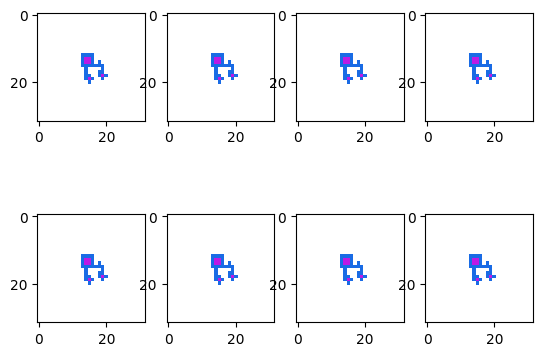

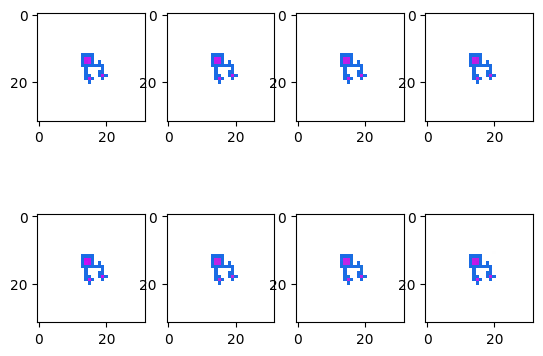

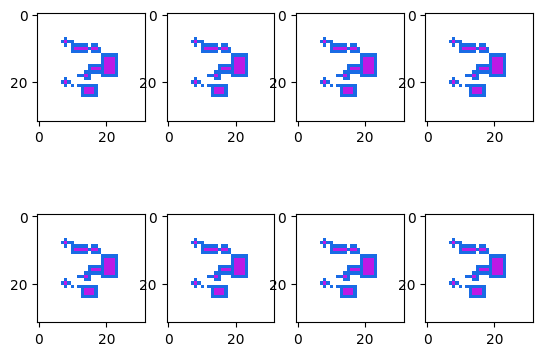

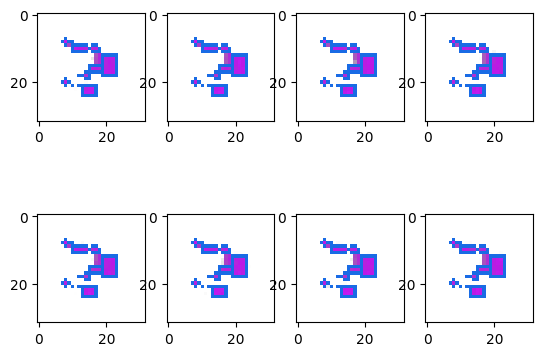

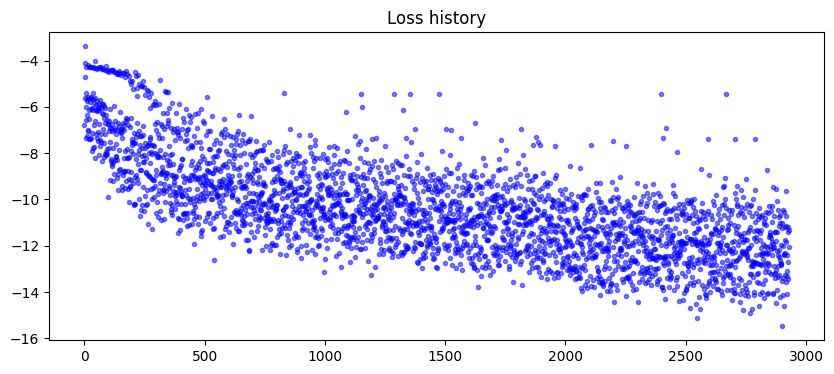

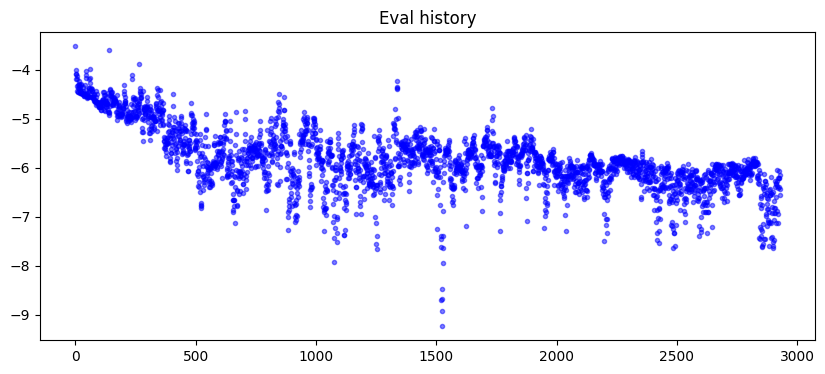

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.0..1.0].
Clipping input data to the valid range for imshow with RGB data ([0..

Loss for problem 0: -6.189421558380127


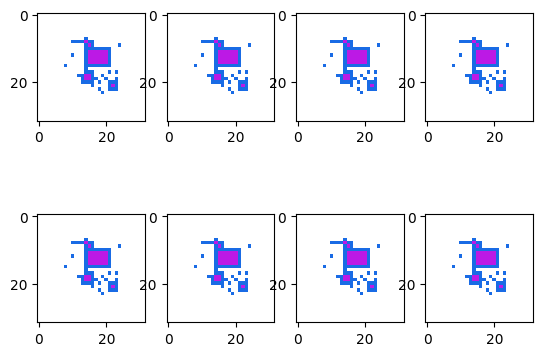

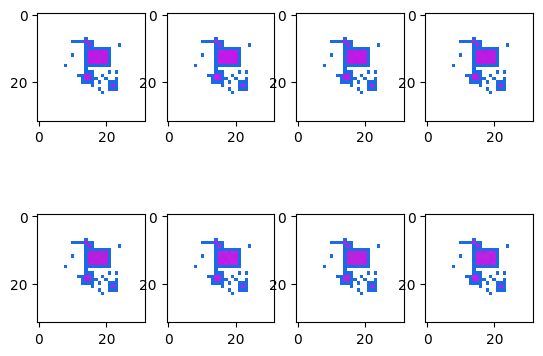

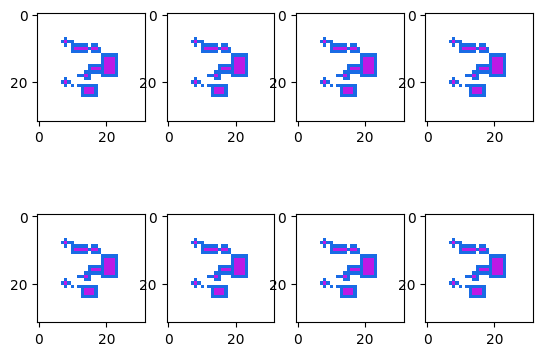

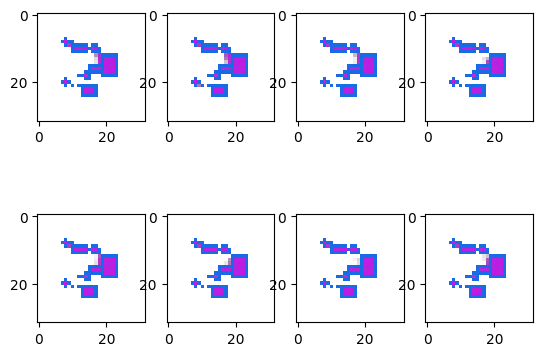

In [6]:
for i in range(start,num_probs):
    make_path("LossesData")
    name_loss = "LossesData/v3_padded_loss.json"    #<--- change name here for new loss saving path
    create_empty_json(name_loss)
    with open(name_loss, "r") as f:
        all_problems_loss_history = json.load(f)
    name_eval = "LossesData/v3_padded_eval.json"    #<--- change name here for new eval saving path
    create_empty_json(name_eval)
    with open(name_eval, "r") as f:
        all_problems_eval_history = json.load(f)

    problem = i
    mode = "rgb"
    genes = [i for i in range(GENESIZE)]

    nca_in = [aau.pad_to_size([32,32],aau.arc_to_nca_space(max_colors, ip, CHANNELS,GENESIZE, mode=mode, gene_location=genes, is_invis=1)) for id,ip in enumerate(inputs[problem])]
    nca_out = [aau.pad_to_size([32,32], aau.arc_to_nca_space(max_colors, ip, CHANNELS,GENESIZE, mode=mode, gene_location=genes, is_invis=1)) for id,ip in enumerate(outputs[problem])]

    eval_nca_in = [aau.pad_to_size([32,32], aau.arc_to_nca_space(max_colors, ip, CHANNELS,GENESIZE, mode=mode, gene_location=genes, is_invis=1)) for id,ip in enumerate(eval_in[problem])]
    eval_nca_out = [aau.pad_to_size([32,32], aau.arc_to_nca_space(max_colors, ip, CHANNELS,GENESIZE, mode=mode, gene_location=genes, is_invis=1)) for id,ip in enumerate(eval_out[problem])]

    pool_x = [n.tile(1024, 1, 1, 1) for n in nca_in]
    xprime = nca_in
    pool_y = nca_out
    folder = "TrainedARCModels"

    eval_log = []
    loss_log = []
    nca = EngramNCA_v3(CHANNELS, vft.GENE_HIDDEN_N, vft.GENE_PROP_HIDDEN_N, GENESIZE)  #<-- change CA here {options: CA, EngramNCA v1, v2 , v3 , v3}

    make_path(folder+ "/" + type(nca).__name__)

    nca = nca.to(DEVICE)
    optim = torch.optim.AdamW(nca.parameters(), lr=1e-3)
    scheduler = torch.optim.lr_scheduler.StepLR(optim, step_size=2000, gamma=0.3)
    name_NCA = folder + "/" + type(nca).__name__ + "/" + "problem_" + str(i) + ".pth"

    for j in range(3000):
        nca.train()
        loss = 0
        with torch.no_grad():
            idx_problem = j % len(pool_x)
            x_prob = pool_x[idx_problem]
            x, idxs = utils.get_batch(x_prob, nca_in[idx_problem].clone(), BATCH_SIZE, noise_level=0.2)
            y = pool_y[idx_problem].tile(BATCH_SIZE, 1, 1, 1)

        itters = random.randrange(32, 64)

        for _ in range(itters):
            x = nca(x, 0.5)
        loss += ((y[:, :4, :, :]) - (x[:, :4, :, :])).pow(2).mean()

        if patch_training:
            xp = torch.nn.functional.unfold(x, kernel_size=3, padding=1, stride=1).view(
                BATCH_SIZE * x.shape[-1] * x.shape[-2], CHANNELS, 3, 3)
            yp = torch.nn.functional.unfold(y, kernel_size=3, padding=1, stride=1).view(
                BATCH_SIZE * y.shape[-1] * y.shape[-2], CHANNELS, 3, 3)
            indexes = random.sample(range(xp.shape[0]), xp.shape[0] // 50)
            xp = xp[indexes]
            yp = yp[indexes]

            for _ in range(itters):
                xp = nca(xp, 0.5)

            loss += (yp[:, :4, :, :] - (xp[:, :4, :, :])).pow(2).mean()

        with torch.no_grad():
            loss.backward()
            for p in nca.parameters():
                p.grad /= (p.grad.norm() + 1e-8)
            optim.step()
            x = x.detach()
            optim.zero_grad()


        with torch.no_grad():
            pool_x = utils.update_problem_pool(pool_x, x.clone(), idxs, idx_problem)
        loss_log.append(loss.log().item() if loss.log().item() < 15 else 15)
        scheduler.step()



        nca.eval()
        with torch.no_grad():
            xe = eval_nca_in[0].clone().tile(BATCH_SIZE, 1, 1, 1)
            ye = eval_nca_out[0].clone().tile(BATCH_SIZE, 1, 1, 1)
            for _ in range(itters):
                xe = nca(xe, 0.5)
            loss_e = (ye[:, :4, :, :] - xe[:, :4, :, :]).pow(2).mean()
            eval_log.append(loss_e.log().item() if loss_e.log().item() < 15 else 15)
            loss_e.detach()
            xe.detach()
            ye.detach()

        if j % 101 == 0:
            plt.figure(1, figsize=(10, 4))
            plt.clf()
            clear_output()
            plt.title('Loss history')
            plt.plot(loss_log, '.', alpha=0.5, color="b")
            plt.figure(2, figsize=(10, 4))
            plt.clf()
            clear_output()
            plt.title('Eval history')
            plt.plot(eval_log, '.', alpha=0.5, color="b")
            plt.show(block=False)
            plt.pause(0.01)
            utils.show_batch(y[0:8], fig_num=6, channels=4)
            utils.show_batch(x[0:8],channels=4)
            utils.show_batch(ye[0:8],fig_num=5,channels=4)
            utils.show_batch(xe[0:8],fig_num=4,channels=4)

    print(f"Loss for problem {i}: {sum(eval_log[-10:])/10}")


    all_problems_loss_history[str(i)] = loss_log
    all_problems_eval_history[str(i)] = eval_log
    torch.save(nca.state_dict(), name_NCA)


    with open(name_loss, "w") as f:
        json.dump(all_problems_loss_history, f)


    with open(name_eval, "w") as f:
        json.dump(all_problems_eval_history, f)